In [58]:
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest,  f_classif, chi2, f_regression
from numpy import *

import pandas as pd
import geopandas as gpd
import numpy  as np

from tobler.area_weighted import area_interpolate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import statsmodels.api as sm

# Plotting
import matplotlib as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [59]:
# Shape file of State of Kansas
fp= 'C:/Users/sarahann.USERS/Desktop/code/cb_2018_us_state_500k.shp' # state shape file. 
kansas = gpd.read_file(fp)
ks_map = kansas.NAME.isin(['Kansas']) 
ks_map = kansas[ks_map].loc[0:]
ks_map.to_crs(epsg=4326, inplace=True)

# County shape file, use for county lines
fp= 'C:/Users/sarahann.USERS/Desktop/code/us_county/US_County_Boundaries.shp' # county file

map_county = gpd.read_file(fp)
# Delete Non-contingous US counties 
ks_county = map_county.STATE.isin(['Kansas'])  
map_county = map_county[ks_county].loc[0:]
map_county.to_crs(epsg=4326, inplace=True)

cluster = gpd.read_file( 'C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/cluster.shp')
cluster.set_crs(epsg=4326, inplace=True)
cluster.head(3)

,cluster,geometry
0,12.0,"POLYGON ((-100.08750 39.99583, -100.07083 39.9..."
1,12.0,"POLYGON ((-100.02917 39.99583, -100.00417 39.9..."
2,12.0,"POLYGON ((-99.42917 39.99583, -99.42083 39.995..."


In [60]:
cluster['cluster'].replace(0, np.NaN, inplace=True)
cluster['macro'] = cluster.cluster //10
cluster['micro'] = cluster.cluster - (cluster.macro *10)
cluster = cluster.loc[cluster[~cluster.isnull().any(axis=1)].index]
cluster.head(3)

,cluster,geometry,macro,micro
0,12.0,"POLYGON ((-100.08750 39.99583, -100.07083 39.9...",1.0,2.0
1,12.0,"POLYGON ((-100.02917 39.99583, -100.00417 39.9...",1.0,2.0
2,12.0,"POLYGON ((-99.42917 39.99583, -99.42083 39.995...",1.0,2.0


In [93]:
cluster.groupby(['macro']).count()

,cluster,geometry,micro
macro,,,
1.0,563,563,563
2.0,4029,4029,4029
3.0,1011,1011,1011


In [61]:
loss_type_per= gpd.read_file('C:/Users/sarahann.USERS/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/loss_type_per.shape/loss_type_per.shp')
loss_type_per.head(3)

,STFIPS,CTFIPS,STATE,COUNTY,VERSION,Shape_Leng,Shape_Area,Cold Wet W,Cold Winte,Drought,...,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces,geometry
0,20,20023,Kansas,cheyenne,05,2.145800,0.277993,0.031073,0.033898,0.313559,...,0.002825,0.042373,0.000000,0.265537,0.062147,0.048023,0.008475,0.028249,0.053672,"POLYGON ((-102.04981 39.57406, -102.04993 39.5..."
1,20,20153,Kansas,rawlins,05,2.213924,0.291303,0.021739,0.024155,0.400966,...,0.002415,0.036232,0.002415,0.188406,0.050725,0.019324,0.000000,0.009662,0.077295,"POLYGON ((-101.41391 39.56832, -101.41361 39.5..."
2,20,20089,Kansas,jewell,05,2.016403,0.249024,0.025641,0.046154,0.376923,...,0.020513,0.056410,0.007692,0.105128,0.035897,0.007692,0.010256,0.007692,0.028205,"POLYGON ((-98.50527 39.56760, -98.50530 39.567..."


In [62]:
loss_type_per.columns.unique()

Index(['STFIPS', 'CTFIPS', 'STATE', 'COUNTY', 'VERSION', 'Shape_Leng',
       'Shape_Area', 'Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi',
       'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects',
       'Plant Dise', 'Wind/Exces', 'geometry'],
      dtype='object')

In [63]:
# Set to common crs projection 
loss_type_per.to_crs(epsg=4326, inplace=True)
loss_type_per.crs == cluster.crs

True

In [64]:
# Interpolate 
loss_per_county = area_interpolate(source_df= loss_type_per, target_df= cluster , intensive_variables=['Cold Wet W', 'Cold Winte', 'Drought',
       'Excess Moi',  'Flood', 'Freeze', 'Frost', 'Hail', 'Heat',
       'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces',])
loss_per_county.head(3)

<ipython-input-64-30f52682fae7>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loss_per_county = area_interpolate(source_df= loss_type_per, target_df= cluster , intensive_variables=['Cold Wet W', 'Cold Winte', 'Drought',
C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\tobler\area_weighted\area_interpolate.py:362: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  den = source_df[source_df.geometry.name].area.values


,Cold Wet W,Cold Winte,Drought,Excess Moi,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces,geometry
0,0.015432,0.009259,0.391975,0.250000,0.003086,0.061728,0.015432,0.126543,0.058642,0.006173,0.0,0.000000,0.061728,"POLYGON ((-100.08750 39.99583, -100.07083 39.9..."
1,0.015432,0.009259,0.391975,0.250000,0.003086,0.061728,0.015432,0.126543,0.058642,0.006173,0.0,0.000000,0.061728,"POLYGON ((-100.02917 39.99583, -100.00417 39.9..."
2,0.010239,0.030717,0.443686,0.167235,0.003413,0.081911,0.027304,0.122867,0.051195,0.006826,0.0,0.020478,0.034130,"POLYGON ((-99.42917 39.99583, -99.42083 39.995..."


In [65]:
loss_per_county=loss_per_county.merge(cluster, on='geometry')
loss_per_county.head(3)

,Cold Wet W,Cold Winte,Drought,Excess Moi,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces,geometry,cluster,macro,micro
0,0.015432,0.009259,0.391975,0.250000,0.003086,0.061728,0.015432,0.126543,0.058642,0.006173,0.0,0.000000,0.061728,"POLYGON ((-100.08750 39.99583, -100.07083 39.9...",12.0,1.0,2.0
1,0.015432,0.009259,0.391975,0.250000,0.003086,0.061728,0.015432,0.126543,0.058642,0.006173,0.0,0.000000,0.061728,"POLYGON ((-100.02917 39.99583, -100.00417 39.9...",12.0,1.0,2.0
2,0.010239,0.030717,0.443686,0.167235,0.003413,0.081911,0.027304,0.122867,0.051195,0.006826,0.0,0.020478,0.034130,"POLYGON ((-99.42917 39.99583, -99.42083 39.995...",12.0,1.0,2.0


In [89]:
X = loss_per_county[[ 'Cold Wet W', 'Cold Winte', 'Drought',
       'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat',
       'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces', 
      ]] 

y = loss_per_county['macro'].astype("category")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

logmodel = LogisticRegression(multi_class='multinomial', solver='lbfgs') 
logmodel.fit(X_train, y_train)
predictions_log=logmodel.predict(X_test)

print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

         1.0       1.00      0.31      0.47       288
         2.0       0.86      0.99      0.92      2001
         3.0       0.59      0.50      0.54       513

    accuracy                           0.83      2802
   macro avg       0.82      0.60      0.64      2802
weighted avg       0.83      0.83      0.81      2802



In [67]:
names = ['Cold Wet W', 'Cold Winte', 'Drought',
       'Excess Moi',  'Flood', 'Freeze', 'Frost', 'Hail', 'Heat',
       'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces', 
      ]

logmodel.score(X_test, y_test)
logmodel.predict_proba(X_test)

array([[3.38739637e-02, 8.32367307e-01, 1.33758729e-01],
       [5.77690380e-04, 9.96492379e-01, 2.92993080e-03],
       [1.25261019e-02, 9.38279653e-01, 4.91942455e-02],
       ...,
       [6.04722457e-01, 4.01636639e-02, 3.55113879e-01],
       [4.03257946e-02, 8.59119692e-01, 1.00554513e-01],
       [4.28460422e-01, 2.40547758e-02, 5.47484802e-01]])

<AxesSubplot:title={'center':'NW Kansas'}>

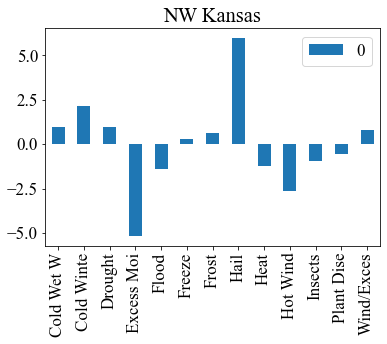

In [68]:
importance= logmodel.coef_
pd.DataFrame(importance[0], index=names).plot.bar(title='NW Kansas')

<AxesSubplot:title={'center':'E Kansas'}>

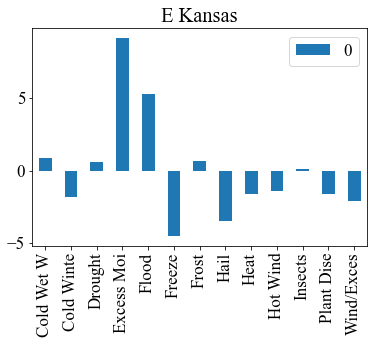

In [69]:
importance= logmodel.coef_
pd.DataFrame(importance[1], index=names).plot.bar(title='E Kansas')

<AxesSubplot:title={'center':'SW KS'}>

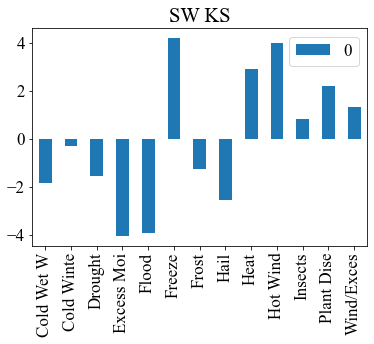

In [70]:
importance= logmodel.coef_
pd.DataFrame(importance[2], index=names).plot.bar(title='SW KS')

In [71]:
uni_cls = loss_per_county.dissolve(by='cluster', aggfunc = 'mean')
uni_cls=uni_cls.reset_index()
uni_cls.head(3)

,cluster,geometry,Cold Wet W,Cold Winte,Drought,Excess Moi,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces,macro,micro
0,11.0,"MULTIPOLYGON (((-102.03750 37.87917, -102.0375...",0.025337,0.021465,0.371705,0.194914,0.015082,0.043274,0.004179,0.143563,0.057515,0.045341,0.004894,0.024553,0.048179,1.0,1.0
1,12.0,"MULTIPOLYGON (((-101.84583 37.88750, -101.8291...",0.025025,0.025806,0.375557,0.214374,0.009742,0.051202,0.007516,0.142371,0.059388,0.026991,0.004479,0.019347,0.038202,1.0,2.0
2,21.0,"MULTIPOLYGON (((-97.62083 37.31250, -97.62083 ...",0.017385,0.005980,0.326818,0.470663,0.049787,0.014975,0.003972,0.030952,0.049543,0.010742,0.004503,0.003082,0.011597,2.0,1.0


In [72]:
df = uni_cls[['Cold Wet W', 'Cold Winte', 'Drought',
       'Excess Moi',  'Flood', 'Freeze', 'Frost', 'Hail', 'Heat',
       'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces']]

values = (pd.DataFrame(df.apply(lambda x: x.nlargest(5).index.tolist(), axis=1).tolist(), columns=['Top (First)','Top (Second)','Top (Third)', 'Top (Fourth)', 'Top (Fifth)']))

np.unique(values)

array(['Drought', 'Excess Moi', 'Flood', 'Freeze', 'Hail', 'Heat',
       'Wind/Exces'], dtype=object)

In [73]:
df

,Cold Wet W,Cold Winte,Drought,Excess Moi,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces
0,0.025337,0.021465,0.371705,0.194914,0.015082,0.043274,0.004179,0.143563,0.057515,0.045341,0.004894,0.024553,0.048179
1,0.025025,0.025806,0.375557,0.214374,0.009742,0.051202,0.007516,0.142371,0.059388,0.026991,0.004479,0.019347,0.038202
2,0.017385,0.005980,0.326818,0.470663,0.049787,0.014975,0.003972,0.030952,0.049543,0.010742,0.004503,0.003082,0.011597
3,0.019596,0.006174,0.303248,0.484112,0.046435,0.017685,0.004248,0.041134,0.045388,0.009942,0.005095,0.003552,0.013393
4,0.019686,0.017812,0.367022,0.261763,0.018338,0.048671,0.003039,0.084582,0.075703,0.043268,0.008042,0.019881,0.032195
5,0.020452,0.015880,0.374261,0.236565,0.009892,0.054070,0.003547,0.102211,0.066848,0.044426,0.008750,0.024984,0.038114


In [74]:
loss_columns = np.unique(values)

In [75]:
[cls_1_1]=uni_cls.loc[uni_cls.cluster == 11][loss_columns].values.tolist()
[cls_1_2]=uni_cls.loc[uni_cls.cluster ==12][loss_columns].values.tolist()
#[cls_1_3]=uni_cls.loc[uni_cls.cluster ==13][loss_columns].values.tolist()

In [76]:
[cls_2_1]=uni_cls.loc[uni_cls.cluster == 21][loss_columns].values.tolist()
[cls_2_2]=uni_cls.loc[uni_cls.cluster ==22][loss_columns].values.tolist()

In [77]:
macro=loss_per_county.dissolve(by='macro', aggfunc = 'mean')
macro=macro.reset_index()
macro.head(3)

,macro,geometry,Cold Wet W,Cold Winte,Drought,Excess Moi,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces,cluster,micro
0,1.0,"MULTIPOLYGON (((-101.82917 37.88750, -101.8291...",0.025111,0.024603,0.374489,0.208982,0.011222,0.049005,0.006591,0.142701,0.058869,0.032075,0.004594,0.020790,0.040967,11.722913,1.722913
1,2.0,"MULTIPOLYGON (((-97.83750 38.00417, -97.83750 ...",0.018465,0.006075,0.315311,0.477229,0.048150,0.016298,0.004107,0.035923,0.047514,0.010352,0.004792,0.003311,0.012474,21.488210,1.488210
2,3.0,"MULTIPOLYGON (((-101.60417 36.99583, -101.6375...",0.020090,0.016792,0.370846,0.248454,0.013877,0.051523,0.003307,0.093893,0.071026,0.043880,0.008416,0.022576,0.035321,31.528190,1.528190


In [78]:
macro[loss_columns]

,Drought,Excess Moi,Flood,Freeze,Hail,Heat,Wind/Exces
0,0.374489,0.208982,0.011222,0.049005,0.142701,0.058869,0.040967
1,0.315311,0.477229,0.048150,0.016298,0.035923,0.047514,0.012474
2,0.370846,0.248454,0.013877,0.051523,0.093893,0.071026,0.035321


macro.columns
loss_columns = ['Cold Wet W', 'Cold Winte', 'Drought',
       'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind',
       'Insects', 'Plant Dise', 'Wind/Exces']

In [79]:
[cls_1]=macro.loc[macro.macro ==1][loss_columns].values.tolist()
[cls_2]=macro.loc[macro.macro ==2][loss_columns].values.tolist()
[cls_3]=macro.loc[macro.macro ==3][loss_columns].values.tolist()

Cluster_1 = [*cls_1, cls_1[0]]
Cluster_2 = [*cls_2, cls_2[0]]
Cluster_3 = [*cls_3, cls_3[0]]

In [80]:
loss_columns

array(['Drought', 'Excess Moi', 'Flood', 'Freeze', 'Hail', 'Heat',
       'Wind/Exces'], dtype=object)

In [81]:
# Update Excess Moisture to Full Spelling
loss_columns[1] = 'Excess Moisture'
loss_columns[6] = 'Wind'

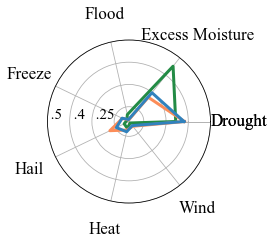

In [83]:
plt.figure(figsize=(3,3))
ax = plt.subplot(111, polar=True)

categories = loss_columns
categories = [*categories, categories[0]]

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] =17

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

plt.plot(label_loc, Cluster_2, label='Zone 2. E KS', color = "#238b45", linewidth=3)
plt.plot(label_loc, Cluster_1, label='Zone 1. NW KS', color='#fc8d59', linewidth=3)
plt.plot(label_loc, Cluster_3, label='Zone 3. SW KS', color =  '#3182bd', linewidth=3)

lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)


#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [1,0,2]

#add legend to plot
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', bbox_to_anchor=(2.5, .1), frameon=False)

# Draw ylabels and internal r labels
ax.set_rlabel_position(-180)
plt.yticks([0.1, .25, .4, .55], [""," .25"," .4", ' .5'], color="black", size=15)
ax.tick_params(pad=18)

plt.savefig('LCR.png', bbox_inches = 'tight', dpi=500)

plt.show()